## Importing Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import os

print(tf.__version__)
print(keras.__version__)

2.0.0-beta1
2.2.4-tf


## Enable Eager Mode

In [2]:
if tf.__version__ < '2.0.0':
    tf.enable_eager_execution()

## Hyper Parameters

In [3]:
learning_rate = 0.001
training_epochs = 15
batch_size = 100
n_class = 10

## MNIST/Fashion MNIST Data

In [4]:
## MNIST Dataset #########################################################
mnist = keras.datasets.mnist
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
##########################################################################

## Fashion MNIST Dataset #################################################
#mnist = keras.datasets.fashion_mnist
#class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
##########################################################################

## Datasets

In [5]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()  

In [6]:
unique, counts = np.unique(train_labels, axis=-1, return_counts=True)
dict(zip(unique, counts))

{0: 5923,
 1: 6742,
 2: 5958,
 3: 6131,
 4: 5842,
 5: 5421,
 6: 5918,
 7: 6265,
 8: 5851,
 9: 5949}

In [7]:
unique, counts = np.unique(test_labels, axis=-1, return_counts=True)
dict(zip(unique, counts))

{0: 980,
 1: 1135,
 2: 1032,
 3: 1010,
 4: 982,
 5: 892,
 6: 958,
 7: 1028,
 8: 974,
 9: 1009}

In [8]:
n_train = train_images.shape[0]
n_test = test_images.shape[0]

In [9]:
# pixel값을 0~1사이 범위로 조정
train_images = train_images.astype(np.float32) / 255.
test_images = test_images.astype(np.float32) / 255.
# CNN에 입력으로 넣기 위해 3차원->4차원으로 변경(channel에 1을 추가)
train_images = np.expand_dims(train_images, axis=-1)
test_images = np.expand_dims(test_images, axis=-1)
# label을 onehot-encoding
train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)    
# Dataset 구성
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(
                buffer_size=100000).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(batch_size)

## Model Function

In [10]:
# Sequential API를 사용하여 model 구성
def create_model():
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='SAME', 
                                  input_shape=(28, 28, 1)))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='SAME'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='SAME'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(256, activation='relu'))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.Dense(10, activation='softmax'))
    return model

In [11]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0

## Loss Function

In [12]:
@tf.function
def loss_fn(model, images, labels):
    predictions = model(images, training=True)
    loss = tf.reduce_mean(keras.losses.categorical_crossentropy(labels, predictions))   
    return loss  

## Calculating Gradient & Updating Weights

In [13]:
@tf.function
def train(model, images, labels):
    with tf.GradientTape() as tape:
        loss = loss_fn(model, images, labels)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

## Caculating Model's Accuracy

In [14]:
@tf.function
def evaluate(model, images, labels):
    predictions = model(images, training=False)
    correct_prediction = tf.equal(tf.argmax(predictions, 1), tf.argmax(labels, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))    
    return accuracy

## Optimizer

In [15]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

## Training

In [16]:
# train my model
print('Learning started. It takes sometime.')
for epoch in range(training_epochs):
    avg_loss = 0.
    avg_train_acc = 0.
    avg_test_acc = 0.
    train_step = 0
    test_step = 0
    
    for images, labels in train_dataset:
        train(model,images, labels)
        loss = loss_fn(model, images, labels)
        acc = evaluate(model, images, labels)
        avg_loss = avg_loss + loss
        avg_train_acc = avg_train_acc + acc
        train_step += 1
    avg_loss = avg_loss / train_step
    avg_train_acc = avg_train_acc / train_step
    
    for images, labels in test_dataset:        
        acc = evaluate(model, images, labels)        
        avg_test_acc = avg_test_acc + acc
        test_step += 1    
    avg_test_acc = avg_test_acc / test_step    

    print('Epoch:', '{}'.format(epoch + 1), 'loss =', '{:.8f}'.format(avg_loss), 
          'train accuracy = ', '{:.4f}'.format(avg_train_acc), 
          'test accuracy = ', '{:.4f}'.format(avg_test_acc))


print('Learning Finished!')

Learning started. It takes sometime.
Epoch: 1 loss = 0.17063929 train accuracy =  0.9593 test accuracy =  0.9850
Epoch: 2 loss = 0.04612609 train accuracy =  0.9896 test accuracy =  0.9860
Epoch: 3 loss = 0.03083074 train accuracy =  0.9936 test accuracy =  0.9914
Epoch: 4 loss = 0.02249131 train accuracy =  0.9956 test accuracy =  0.9926
Epoch: 5 loss = 0.01845846 train accuracy =  0.9968 test accuracy =  0.9935
Epoch: 6 loss = 0.01414392 train accuracy =  0.9978 test accuracy =  0.9931
Epoch: 7 loss = 0.01263226 train accuracy =  0.9982 test accuracy =  0.9926
Epoch: 8 loss = 0.01009062 train accuracy =  0.9986 test accuracy =  0.9922
Epoch: 9 loss = 0.00857571 train accuracy =  0.9989 test accuracy =  0.9925
Epoch: 10 loss = 0.00776338 train accuracy =  0.9991 test accuracy =  0.9941
Epoch: 11 loss = 0.00828564 train accuracy =  0.9992 test accuracy =  0.9933
Epoch: 12 loss = 0.00689901 train accuracy =  0.9993 test accuracy =  0.9924
Epoch: 13 loss = 0.00561468 train accuracy =  0.

In [17]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img[:,:,0],cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    #plt.xticks([])
    plt.xticks(range(n_class), class_names, rotation=90)
    plt.yticks([])
    thisplot = plt.bar(range(n_class), predictions_array, color="#777777")
    plt.ylim([0, 1]) 
    predicted_label = np.argmax(predictions_array)
 
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

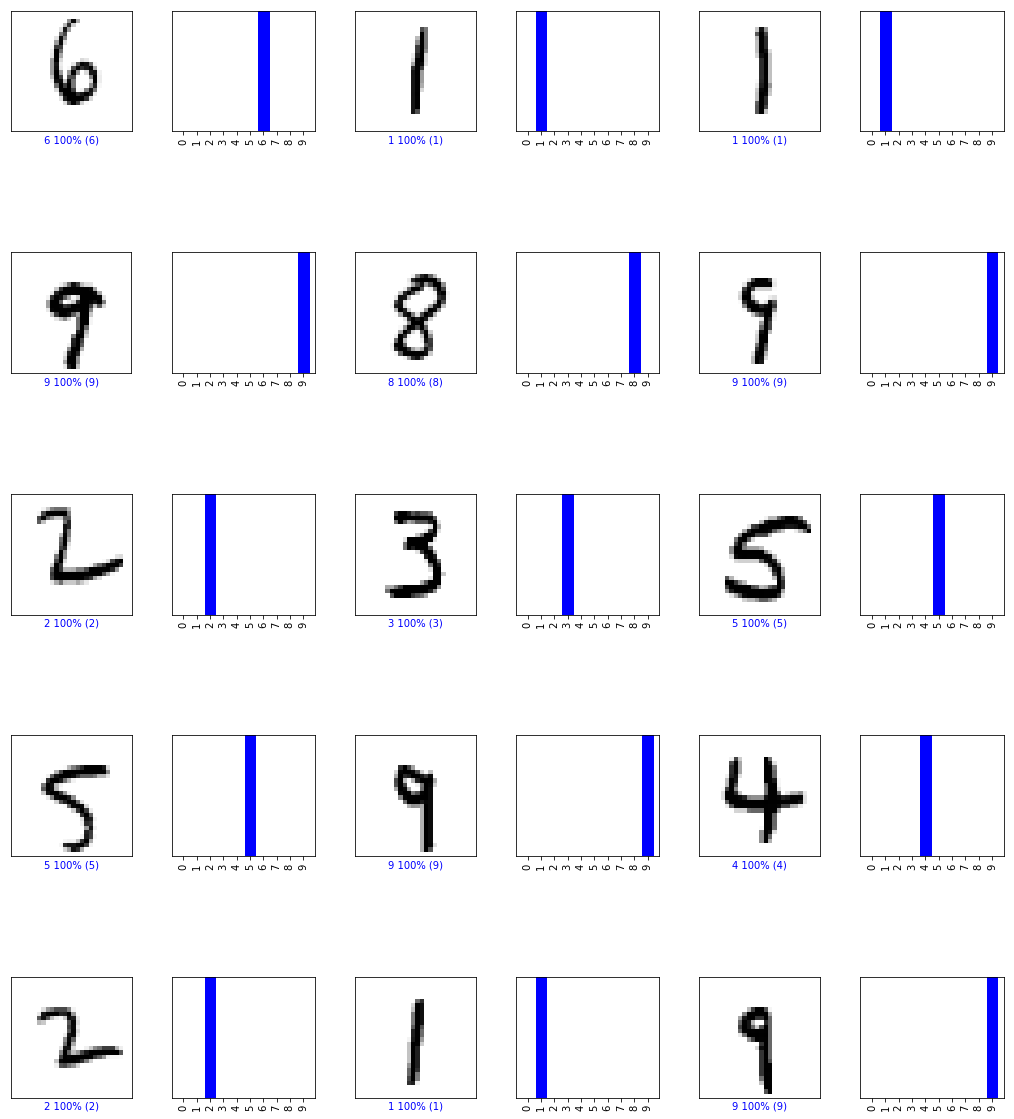

In [18]:
rnd_idx = np.random.randint(1, n_test//batch_size)
img_cnt = 0
for images, labels in test_dataset:
    img_cnt += 1
    if img_cnt != rnd_idx:
        continue
    predictions = model(images, training=False)
    num_rows = 5
    num_cols = 3
    num_images = num_rows*num_cols
    labels = tf.argmax(labels, axis=-1)
    plt.figure(figsize=(3*2*num_cols, 4*num_rows))
    plt.subplots_adjust(hspace=1.0)
    for i in range(num_images):
        plt.subplot(num_rows, 2*num_cols, 2*i+1)
        plot_image(i, predictions.numpy(), labels.numpy(), images.numpy())
        plt.subplot(num_rows, 2*num_cols, 2*i+2)
        plot_value_array(i, predictions.numpy(), labels.numpy())        
    break

# Creating a Checkpoint Directory

In [19]:
cur_dir = os.getcwd()
ckpt_dir_name = 'checkpoints'
model_dir_name = 'minst_cnn_seq'

checkpoint_dir = os.path.join(cur_dir, ckpt_dir_name, model_dir_name)
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_prefix = os.path.join(checkpoint_dir, model_dir_name)

# Saving Weights

In [20]:
model.save_weights(checkpoint_prefix)

# Calculating Average Accuracy

In [21]:
def avg_accuracy(model, dataset):
    avg_acc = 0.
    step = 0
    for images, labels in dataset:        
        predictions = model(images, training=False)
        correct_prediction = tf.equal(tf.argmax(predictions, 1), tf.argmax(labels, 1))
        acc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))     
        avg_acc += acc
        step += 1    
    avg_acc = avg_acc / step
    return avg_acc.numpy()

# Creating a New Model

In [22]:
new_model = create_model()

# Test Accuracy before Restore

In [23]:
avg_accuracy(new_model, test_dataset)

0.13609996

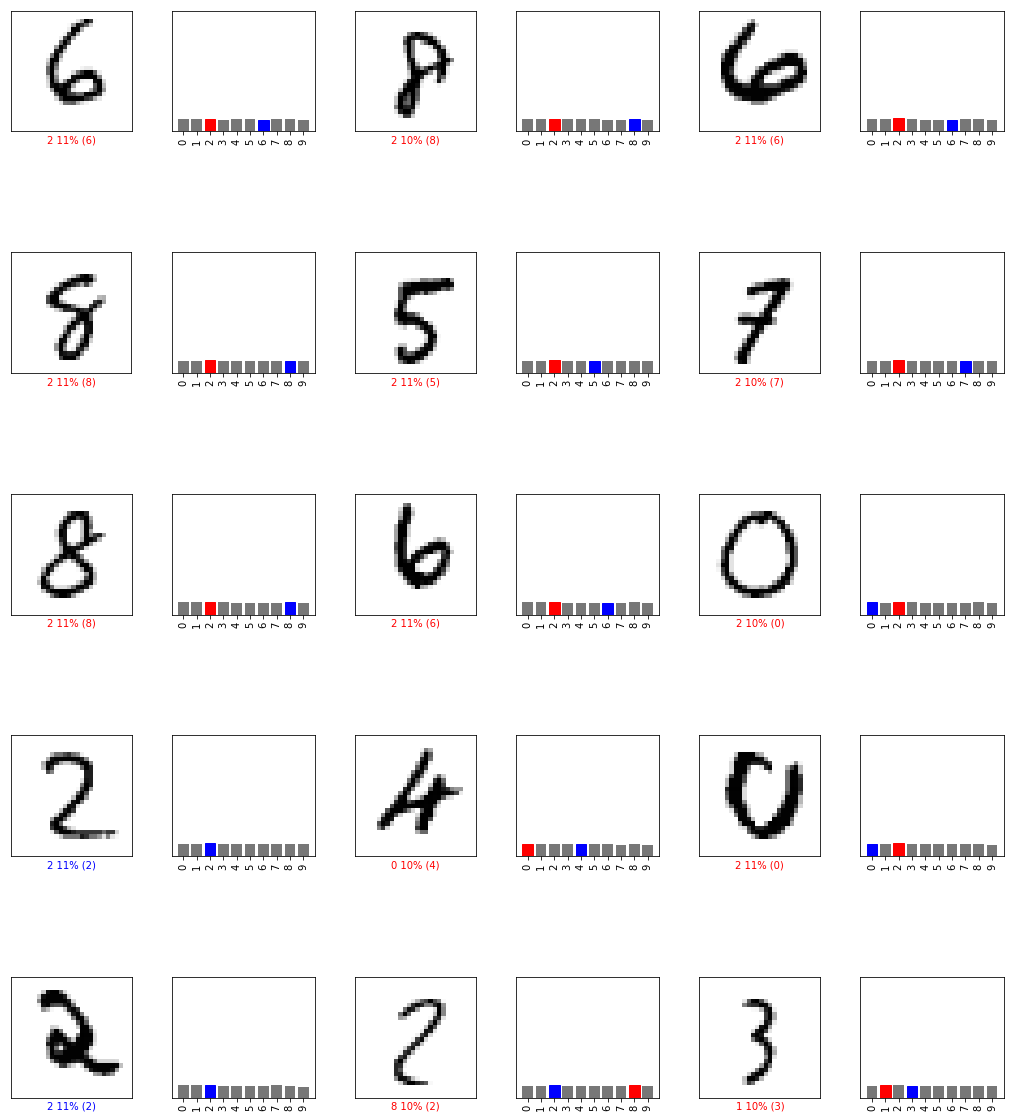

In [24]:
rnd_idx = np.random.randint(1, n_test//batch_size)
img_cnt = 0
for images, labels in test_dataset:
    img_cnt += 1
    if img_cnt != rnd_idx:
        continue
    predictions = new_model(images, training=False)
    num_rows = 5
    num_cols = 3
    num_images = num_rows*num_cols
    labels = tf.argmax(labels, axis=-1)
    plt.figure(figsize=(3*2*num_cols, 4*num_rows))
    plt.subplots_adjust(hspace=1.0)
    for i in range(num_images):
        plt.subplot(num_rows, 2*num_cols, 2*i+1)
        plot_image(i, predictions.numpy(), labels.numpy(), images.numpy())
        plt.subplot(num_rows, 2*num_cols, 2*i+2)
        plot_value_array(i, predictions.numpy(), labels.numpy())        
    break

# Restore Weights

In [25]:
new_model.load_weights(checkpoint_prefix)

# Test Accuracy after Restore

In [26]:
avg_accuracy(new_model, test_dataset)

0.99290013

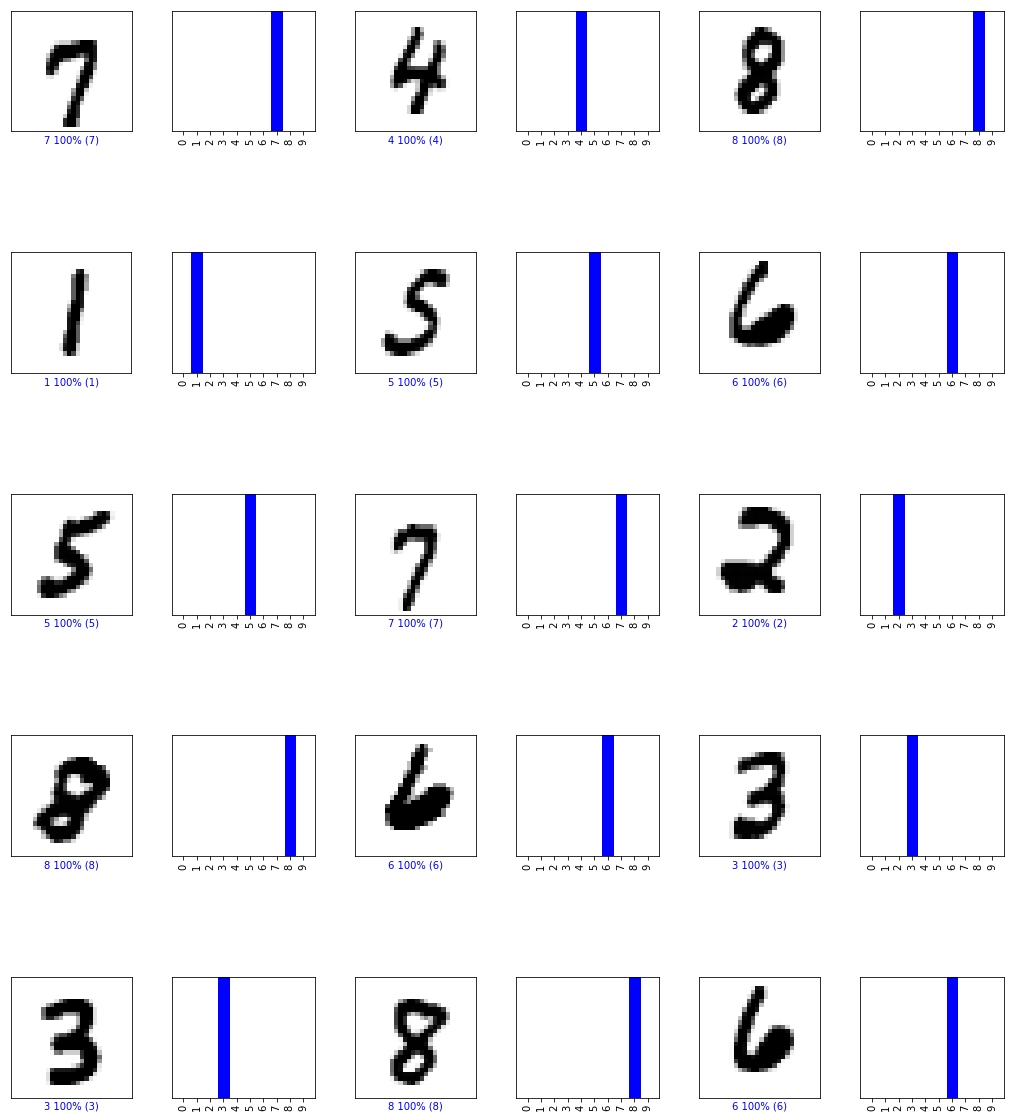

In [27]:
rnd_idx = np.random.randint(1, n_test//batch_size)
img_cnt = 0
for images, labels in test_dataset:
    img_cnt += 1
    if img_cnt != rnd_idx:
        continue
    predictions = new_model(images, training=False)
    num_rows = 5
    num_cols = 3
    num_images = num_rows*num_cols
    labels = tf.argmax(labels, axis=-1)
    plt.figure(figsize=(3*2*num_cols, 4*num_rows))
    plt.subplots_adjust(hspace=1.0)
    for i in range(num_images):
        plt.subplot(num_rows, 2*num_cols, 2*i+1)
        plot_image(i, predictions.numpy(), labels.numpy(), images.numpy())
        plt.subplot(num_rows, 2*num_cols, 2*i+2)
        plot_value_array(i, predictions.numpy(), labels.numpy())        
    break

# Save the Entire Model

## 1. Using HDF5

In [35]:
save_dir_name = 'saved_models'
os.makedirs(save_dir_name, exist_ok=True)
saved_model_path = os.path.join(cur_dir, save_dir_name, 'my_model.h5')
saved_model_path

'c:\\Work\\for13\\13th\\saved_models\\my_model.h5'

In [36]:
model.save(saved_model_path)

## 2. Using saved_model

In [37]:
saved_model_path = os.path.join(cur_dir, save_dir_name, 'my_saved_model')

keras.experimental.export_saved_model(model, saved_model_path)
saved_model_path

'c:\\Work\\for13\\13th\\saved_models\\my_saved_model'